# NIST Scrape 
Starting from this work:

1) https://pubs.acs.org/doi/pdf/10.1021/acs.analchem.1c00867

2) https://github.com/Ohio-State-Allen-Lab/FTIRMachineLearning

3) https://www.linkedin.com/pulse/unofficial-nist-webbook-api-how-get-thermochemistry-data-contreras/?trk=pulse-article_more-articles_related-content-card

4) https://github.com/oscarcontrerasnavas/nist-webbook-API

5) https://github.com/nzhagen/jcamp
      RUN IN COMMAND LINE: 1 ) python -m pip install git+https://github.com/nzhagen/jcamp

My work stored here: 

https://github.com/kevinpatrickkent/FTIRMachineLearning/

In [1]:
# Kevin Patrick Kent
# updated from original code at https://github.com/Ohio-State-Allen-Lab/FTIRMachineLearning

import os
import requests, urllib
import argparse
import logging
import pandas as pd 
import jcamp #Planning to use this later to import all of the .jdx files
import matplotlib.pyplot as plt
import numpy as np
import pickle
#from model.utils import set_logger
# Was not able to run this on the first runthrough.  Will try this again later after investigation but continuing for now.

In [2]:
nist_url = "https://webbook.nist.gov/cgi/cbook.cgi"

# Get Dataframe of all Molecules in NIST Webbook

Used webbook API from here: https://github.com/oscarcontrerasnavas/nist-webbook-API

In [37]:
# I chose 40000 here because there are currently 37495 molecules on webbook

# Perform an inital query to see how many items are present in the database
url = 'https://nist-api.fly.dev/substances?page=1&per_page=10'
response = requests.get(url)
json = response.json()
tot = json['totalItems'] #Get the total number of items and store it for the next request

url = 'https://nist-api.fly.dev/substances?page=1&per_page=' + str(tot+1000)
response = requests.get(url) 
json = response.json()
df = pd.DataFrame(json['items'])
df.head()

# Here I'm making the cas the index for easy referencing

df.set_index('cas', inplace = True)

# Define Function for Scraping the IR Spectra from Webbook

Used the function from here: https://github.com/Ohio-State-Allen-Lab/FTIRMachineLearning

In [4]:
def scrape_data(cas_ls, params, data_dir):
	'''Collect data from NIST database and store them in jdx format.
    Args:
        cas_ls: (list) CAS ids to download data for
		params: (dict) queries to be added to url
		data_dir: (string) path to store the data
    Returns:
        None
    '''	
    
    #Create directory for the relevant spetra 
	spectra_path = os.path.join(data_dir, params['Type'].lower(), '')
	if not os.path.exists(spectra_path):
		os.makedirs(spectra_path)

	num_created = 0
	for cas_id in cas_ls:
		params['JCAMP'] = 'C' + cas_id
		response = requests.get(nist_url, params=params)

		if response.text == '##TITLE=Spectrum not found.\n##END=\n':
			continue
		num_created+=1
		logging.info('Creating {} spectra for id: {}. Total spectra created {}'.format(params['Type'].lower(), cas_id, num_created))
		with open(spectra_path +cas_id +'.jdx', 'wb') as data:
			data.write(response.content)

<b> Note that I ran this once and then just worked from the downloaded .jdx files.

In [5]:
# Do not run this each time as it takes several hours to download these spectra

#Create data directory to store logs and spectra
data_dir = './data'
if not os.path.exists(data_dir):
	os.makedirs(data_dir)

logging.info('Scrape IR spectra')
# Taking this out because I'm running from the command line
#if args.scrap_IR:
cas_ids = df.cas
params={'JCAMP': '', 'Type': 'IR', 'Index': 0}	
scrape_data(cas_ids, params, data_dir)

# Pull in All of the Data from the JCAMP files with jcamp

https://github.com/nzhagen/jcamp 

Text(0, 0.5, 'TRANSMITTANCE')

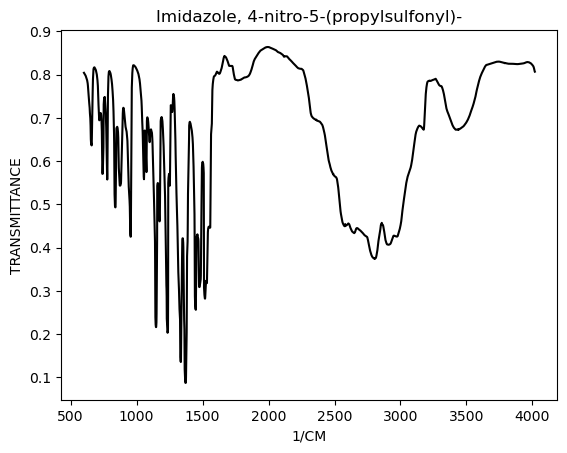

In [5]:
# Making sure I'm able to get the data with the jcamp module

path = 'C:\\Users\\kevin\\Documents\\Python Scripts\\data\\ir\\'
cas = 99980286
data = jcamp.jcamp_readfile(path + str(cas) + '.jdx')

plt.figure()
plt.plot(data['x'], data['y'], color = 'black')
plt.title(data['title'])
plt.xlabel(data['xunits'])
plt.ylabel(data['yunits'])

In [6]:
data

{'title': 'Imidazole, 4-nitro-5-(propylsulfonyl)-',
 'jcamp-dx': 4.24,
 'data type': 'INFRARED SPECTRUM',
 'class': 'COBLENTZ III',
 'origin': 'SOUTHERN RESEARCH INSTITUTE',
 'owner': 'Copyright (C) 1987 by the Coblentz Society\nCollection (C) 2018 copyright by the U.S. Secretary of Commerce\non behalf of the United States of America. All rights reserved.',
 'date': '1959/11/23',
 'names': '4-nitro-5-(propylsulfonyl)-1H-imidazole\n4-nitro-1H-imidazol-5-yl propyl sulfone',
 'cas registry no': '99980-28-6',
 'molform': 'C6 H9 N3 O4 S',
 'source reference': 'COBLENTZ NO. 7840',
 '$nist source': 'COBLENTZ',
 '$nist image': 'cob7840',
 'spectrometer/data system': 'PERKIN-ELMER 21 (GRATING)',
 'instrument parameters': 'FILTER CHANGE ABOUT 1025 CM^-^1',
 'state': 'SOLID (1 mg / 650 mg KBr DISC)',
 'sampling procedure': 'TRANSMISSION',
 'resolution': 2,
 'data processing': 'DIGITIZED BY COBLENTZ SOCIETY (BATCH II) FROM HARD COPY (ADJUSTED \\addcm-1\\20-10-2\\)',
 'xunits': '1/CM',
 'yunits': '

In [7]:
## Here I'm just going through my strategy for one jcamp before looping through all of them
# Setting the dict that I'll be adding all of the spectra to

spec_dict = {'cas':[], 'x':[], 'y':[]}
spec_dict['cas'].append(str(cas))
spec_dict['x'].append(data['x'])
spec_dict['y'].append(data['y'])

print(spec_dict)

# Then I will drop the spectra from the jcamp dict

del data['x']
del data['y']

meta_dict = {'cas':[str(cas)]}
for key in data:
    meta_dict[key] = [data[key]]

print(meta_dict)



{'cas': ['99980286'], 'x': [array([ 601.565714 ,  602.5699556,  603.5741972, ..., 4015.987275 ,
       4016.9936375, 4018.       ])], 'y': [array([0.8043, 0.8036, 0.8032, ..., 0.8088, 0.8075, 0.8069])]}
{'cas': ['99980286'], 'title': ['Imidazole, 4-nitro-5-(propylsulfonyl)-'], 'jcamp-dx': [4.24], 'data type': ['INFRARED SPECTRUM'], 'class': ['COBLENTZ III'], 'origin': ['SOUTHERN RESEARCH INSTITUTE'], 'owner': ['Copyright (C) 1987 by the Coblentz Society\nCollection (C) 2018 copyright by the U.S. Secretary of Commerce\non behalf of the United States of America. All rights reserved.'], 'date': ['1959/11/23'], 'names': ['4-nitro-5-(propylsulfonyl)-1H-imidazole\n4-nitro-1H-imidazol-5-yl propyl sulfone'], 'cas registry no': ['99980-28-6'], 'molform': ['C6 H9 N3 O4 S'], 'source reference': ['COBLENTZ NO. 7840'], '$nist source': ['COBLENTZ'], '$nist image': ['cob7840'], 'spectrometer/data system': ['PERKIN-ELMER 21 (GRATING)'], 'instrument parameters': ['FILTER CHANGE ABOUT 1025 CM^-^1'], 'st

In [16]:
# This is another to not run everytime.

path = 'C:\\Users\\kevin\\Documents\\Python Scripts\\data\\ir\\'
spec_dict = {'cas':[], 'x':[], 'y':[]}
meta_keys = ['cas', 'title', 'jcamp-dx', 'data type', 'origin', 'owner', 'cas registry no', 'molform', '$nist source', 'state', 'xunits', 'yunits', 'xfactor', 'yfactor', 'deltax', 'firstx', 'lastx', 'firsty', 'maxx', 'minx', 'maxy', 'miny', 'npoints', 'xydata', 'end', 'filename', 'date', '$nist doc file', '$nist psd file', 'spectrometer/data system', 'aperture', 'external diffuse reflectance accessory', 'beamsplitter', 'detector (dia. det. port in sphere)', 'sphere diameter', 'acquisition mode', 'scanner speed', 'coadded scans', 'phase resolution', 'phase correction', 'zerofilling', 'spectral range', 'resolution', 'spectral resolution', 'wavenumber accuracy', 'apodization function', 'low pass filter', 'switch gain on', 'xlabel', 'ylabel', 'class', 'source reference', '$nist image', 'sampling procedure', 'data processing', 'instrument parameters', 'names', 'path length', 'bp', 'instrument resolution', 'ir source', 'detector', 'interferogram zerofill', 'spectral interval after zerofilling', 'apodization', 'folding limits', 'number of interferograms averaged per single channel spectrum', 'mp', 'cas name', 'sample description', 'temperature', '$spectra version', '$uncertainty in y', 'pressure', '$nist id']
meta_dict = {}
for key in meta_keys:
    meta_dict[key] = []
IRSpecCount = 0
NoIRSpecCount = 0

for cas in df.index:
    try:
        data = jcamp.jcamp_readfile(path + cas + '.jdx')
        IRSpecCount += 1
    except:
        NoIRSpecCount += 1
        continue
    
    spec_dict['cas'].append(cas)
    spec_dict['x'].append(data['x'])
    
    spec_dict['y'].append(data['y'])
    del data['x']
    del data['y']
    
    for key in meta_dict:
        if key in data:
            meta_dict[key].append(data[key])
        elif key == 'cas':
            meta_dict[key].append(cas)
        else:
            meta_dict[key].append(np.NaN)

print('This many compounds have IR Spectra:', IRSpecCount)
print('This many compounds have do not have IR Spectra:', NoIRSpecCount)

This many compounds have IR Spectra: 14286
This many compounds have do not have IR Spectra: 23659


In [8]:
# Not running this one because I didn't load this time.

meta_df = pd.DataFrame.from_dict(meta_dict)
meta_df.set_index('cas', inplace = True)

meta_df.head()

,title,jcamp-dx,data type,class,origin,owner,date,names,cas registry no,molform,...,lastx,firsty,maxx,minx,maxy,miny,npoints,xydata,end,filename
cas,,,,,,,,,,,,,,,,,,,,,
99980286,"Imidazole, 4-nitro-5-(propylsulfonyl)-",4.24,INFRARED SPECTRUM,COBLENTZ III,SOUTHERN RESEARCH INSTITUTE,Copyright (C) 1987 by the Coblentz Society\nCo...,1959/11/23,4-nitro-5-(propylsulfonyl)-1H-imidazole\n4-nit...,99980-28-6,C6 H9 N3 O4 S,...,4018,0.8043,4018,601.566,0.8642,0.086891,3403,(X++(Y..Y)),,C:\Users\kevin\Documents\Python Scripts\data\i...


In [30]:
#Not running this one because I didn't load this time.
#Just outputting the data so that I can avoid loading all of this again.

meta_df.to_csv('meta_df.csv')

pickle.dump( spec_dict, open( "spec_dict.p", "wb" ) )

In [35]:
# Need to add in a load function right here so that I can skip the part above.
# Alright there we go picking up from here.  Will need to come back and make this less clunky.
# Maybe I'll just have a whole section of 'run this once' type of code

meta_df = pd.read_csv('meta_df.csv')
meta_df.loc[:,'cas'] = meta_df.loc[:,'cas'].astype(str) #Had to set this line because pandas made cas an int64
meta_df.set_index('cas', inplace = True)

spec_dict = pd.read_pickle('spec_dict.p')

C:\Users\kevin\AppData\Local\Temp\ipykernel_10900\585516734.py:5: DtypeWarning: Columns (27,28,30,31,32,33,34,35,36,39,41,42,43,44,45,46,47,59,60,61,62,63,64,65,66,69,70,72,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_df = pd.read_csv('meta_df.csv')


In [38]:
# Now merging the spectral data into the original NIST Webbook Database

df = df.join(meta_df)

df.head()

,name,formula,molecular_weight,image,title,jcamp-dx,data type,origin,owner,cas registry no,...,folding limits,number of interferograms averaged per single channel spectrum,mp,cas name,sample description,temperature,$spectra version,$uncertainty in y,pressure,$nist id
cas,,,,,,,,,,,,,,,,,,,,,
74828,methane,CH4,16.0425,https://webbook.nist.gov/cgi/cbook.cgi?Struct=...,Methane,4.24,INFRARED SPECTRUM,Sadtler Research Labs Under US-EPA Contract,NIST Standard Reference Data Program\nCollecti...,74-82-8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58855,biotin,C10H16N2O3S,244.3110,https://webbook.nist.gov/cgi/cbook.cgi?Struct=...,Biotin,4.24,INFRARED SPECTRUM,Pacific Northwest National Laboratory Under IA...,Public domain,58-85-5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
625081,"butanoic acid, 3-hydroxy-3-methyl-",C5H10O3,118.1311,https://webbook.nist.gov/cgi/cbook.cgi?Struct=...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1314916,lead telluride,PbTe,334.8000,https://webbook.nist.gov/cgi/cbook.cgi?Struct=...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16853740,ditungsten zirconium octaoxide,O8W2Zr,586.9000,https://webbook.nist.gov/cgi/cbook.cgi?Struct=...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# Dropping the rows without any IR spectral data

print('Here is how many rows will be dropped (consistent with above):', df['title'].isna().sum())

df = df.drop(labels = df.loc[df['title'].isna(),:].index.tolist())

Here is how many rows will be dropped (consistent with above): 23659


# Data Exploration and Cleaning

In [42]:
df.columns

Index(['name', 'formula', 'molecular_weight', 'image', 'title', 'jcamp-dx',
       'data type', 'origin', 'owner', 'cas registry no', 'molform',
       '$nist source', 'state', 'xunits', 'yunits', 'xfactor', 'yfactor',
       'deltax', 'firstx', 'lastx', 'firsty', 'maxx', 'minx', 'maxy', 'miny',
       'npoints', 'xydata', 'end', 'filename', 'date', '$nist doc file',
       '$nist psd file', 'spectrometer/data system', 'aperture',
       'external diffuse reflectance accessory', 'beamsplitter',
       'detector (dia. det. port in sphere)', 'sphere diameter',
       'acquisition mode', 'scanner speed', 'coadded scans',
       'phase resolution', 'phase correction', 'zerofilling', 'spectral range',
       'resolution', 'spectral resolution', 'wavenumber accuracy',
       'apodization function', 'low pass filter', 'switch gain on', 'xlabel',
       'ylabel', 'class', 'source reference', '$nist image',
       'sampling procedure', 'data processing', 'instrument parameters',
       'names',

In [43]:
# Here I'm going to need to decide what to work on for the project.  Start with gas spectra likely as the largest sample size

#set this to count it as False if the state was empty - may come back to this later
gas = df.state.str.lower().str.contains('gas', na = False)

print(df.state.value_counts()[df.state.value_counts()>8])


gas                                                            8183
SOLID (MINERAL OIL MULL)                                        417
LIQUID                                                          413
LIQUID (NEAT)                                                   337
SOLID (KBr PELLET)                                              300
                                                               ... 
SOLID (1 mg / 200 mg KBr DISC) VS KBr                             9
liquid                                                            9
SOLID (KCl DISC) VS KCl                                           9
SOLUTION (10% CCl4 FOR 2.5-7.5, 10% CS2 FOR 7.5-16 MICRONS)       9
SOLUTION (10% CCl4 FOR 2.5-7.5, 10% CS2 FOR 7.5-15 MICRON)        9
Name: state, Length: 67, dtype: int64


In [44]:
# Here is something interesting.  There are 809 unlabelled states. Will have to come back to this later.
# This bumped up to 810... Hmmm some other problem in the load

df.state.isna().sum()

810

In [45]:
# What are all of our states that contain gas?

df.loc[gas,:].state.value_counts()

gas                                                                     8183
GAS (100 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                          9
GAS (50 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                           8
GAS                                                                        6
GAS (80 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                           2
GAS (100 mmHg DILUTED TO A TOTAL PRESSURE OF 600 mmHg WITH N2)             2
GAS (200 mmHg DILUTED TO A TOTAL PRESSURE OF 600 mmHg WITH N2)             2
GAS (10 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                           2
GAS (600 mmHg DILUTED TO A TOTAL PRESSURE OF 600 mmHg WITH N2)             2
GAS (60 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                           2
GAS (40 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                           1
GAS (150 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                          1
GAS (106 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                          1

In [46]:
# Defining a new column called clean_state.  I'm going to relabel all of the gas labels above as 'gas'

df['clean_state'] = np.NaN
df.loc[gas,'clean_state'] = 'gas'

In [47]:
# Now check to make sure I did that right
# Will have to do something similar with liquid, solid and solution

df.loc[gas,:].clean_state.value_counts()

gas    8239
Name: clean_state, dtype: int64

In [48]:
# What are the units for y?  All the same? Close one is in extinction coefficient units but if I normalize that won't matter
# With the transmittance spectra I need to convert to absorbance

df.loc[gas,:].yunits.value_counts()

ABSORBANCE                       8183
TRANSMITTANCE                      55
(micromol/mol)-1m-1 (base 10)       1
Name: yunits, dtype: int64

In [49]:
df.loc[gas,'xydata'].value_counts()

(X++(Y..Y))    8239
Name: xydata, dtype: int64

In [50]:
# What about x?  I need to convert micrometers to wavenumbers.  The cm-1 is the same as 1/cm (wavenumbers)

df.loc[gas,:].xunits.value_counts()

1/CM           8230
MICROMETERS       8
cm-1              1
Name: xunits, dtype: int64

In [51]:
# Just quickly fixing the cm-1

quick_cm = (df.loc[gas,:].xunits == 'cm-1').tolist()

df.loc['354336','xunits'] = '1/CM'

df.loc[gas,:].loc[quick_cm,'xunits']


cas
354336    1/CM
Name: xunits, dtype: object

In [52]:
# Check to see if it's fixed.

df.loc[gas,:].xunits.value_counts()

1/CM           8231
MICROMETERS       8
Name: xunits, dtype: int64

Text(0.5, 1.0, 'Missing Data in Each Column')

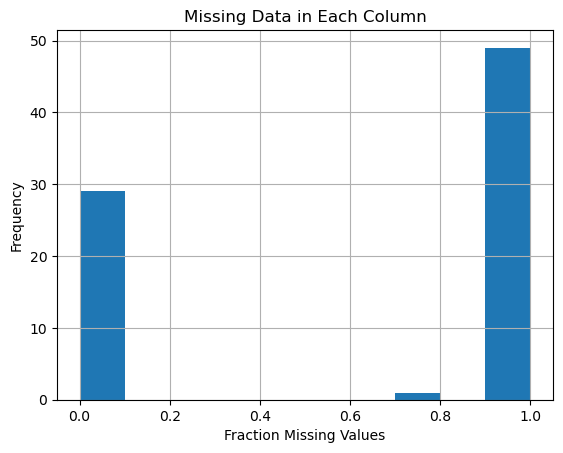

In [55]:
# How many NaNs?  Need to look into this a bit further - probably several columns I can just drop

ax = (df.loc[gas,:].isna().sum()/df.loc[gas,:].shape[0]).hist()
ax.set_xlabel('Fraction Missing Values')
ax.set_ylabel('Frequency')
ax.set_title('Missing Data in Each Column')

In [56]:
# Getting a quick look at the columns so I can choose which ones to convert from wavelenght to wavenumber

df.columns

Index(['name', 'formula', 'molecular_weight', 'image', 'title', 'jcamp-dx',
       'data type', 'origin', 'owner', 'cas registry no', 'molform',
       '$nist source', 'state', 'xunits', 'yunits', 'xfactor', 'yfactor',
       'deltax', 'firstx', 'lastx', 'firsty', 'maxx', 'minx', 'maxy', 'miny',
       'npoints', 'xydata', 'end', 'filename', 'date', '$nist doc file',
       '$nist psd file', 'spectrometer/data system', 'aperture',
       'external diffuse reflectance accessory', 'beamsplitter',
       'detector (dia. det. port in sphere)', 'sphere diameter',
       'acquisition mode', 'scanner speed', 'coadded scans',
       'phase resolution', 'phase correction', 'zerofilling', 'spectral range',
       'resolution', 'spectral resolution', 'wavenumber accuracy',
       'apodization function', 'low pass filter', 'switch gain on', 'xlabel',
       'ylabel', 'class', 'source reference', '$nist image',
       'sampling procedure', 'data processing', 'instrument parameters',
       'names',

In [81]:
# Next cleaning task is clear we need to convert from micrometers to 1/cm
# Conversion is wavenumber (1/CM) = 10^4 / wavelength (micrometers)

def wavenumber(wavelength):
    ''' Simple function to convert from wavelength in micrometers to wavenumber is inverse centimeter.'''
    return (10**4)/wavelength

In [85]:
# In order to make this conversion we need to do the following.
# 1) Convert the meta data that will be used in wavenumbers (several items).
# 2) Convert the x-values for the spectra to wavenumbers.

def convert(cas):
    ''' Collecting all the conversion tasks for wavelength to wavenumber into a function.'''
    meta_mods = ['deltax', 'firstx', 'lastx', 'maxx', 'minx']
    for key in meta_mods:
        df.loc[cas,key] = wavenumber(df.loc[cas,key])
    
    # Find the location of the spectrum and convert x to wavenumber
    ind = spec_dict['cas'].index(cas)
    spec_dict['x'][ind] = wavenumber(spec_dict['x'][ind])
    
    # Lastly change the unit to the new unit
    df.loc[cas,'xunits'] = '1/CM'
    
    return
    

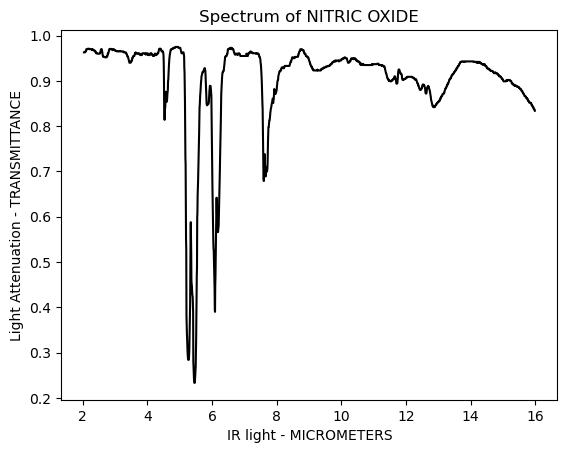

Text(0.5, 1.0, 'Check Before x-axis Conversion')

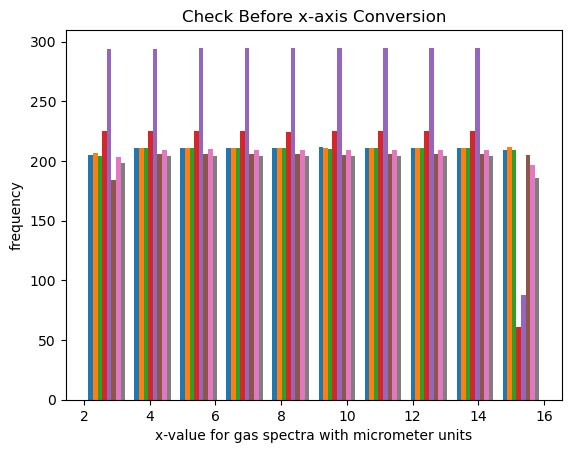

In [80]:
# Before I run this function I want to have some visualization of the x-values from spec_dict
# to make sure that I've done what I expect to do

x_check = []
microm = df.xunits.str.lower().str.contains('micrometer', na = False)

i = 0
for cas in df.loc[gas & microm,:].index:
    ind = spec_dict['cas'].index(cas)
    if i == 0:
        plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
        plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
        plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
        plt.title('Spectrum of ' + df.loc[cas,'title'])
        plt.show()
    x_check.append(spec_dict['x'][ind].tolist())
    i += 1

plt.hist(x_check)

plt.xlabel('x-value for gas spectra with micrometer units')
plt.ylabel('frequency')
  
plt.title('Check Before x-axis Conversion')
    

In [86]:
# Run the function to convert to wavenumber

for cas in df.loc[gas & microm, :].index:
    convert(cas)

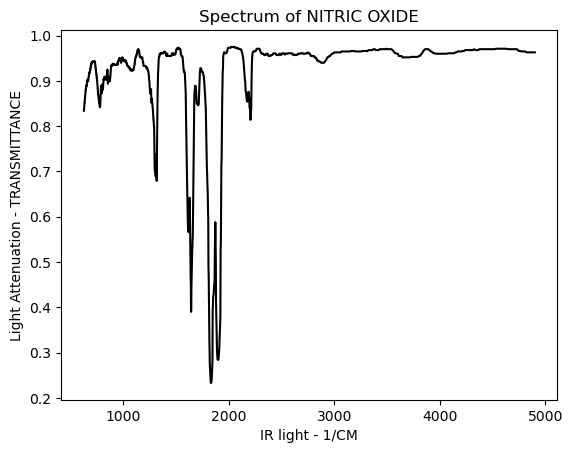

Text(0.5, 1.0, 'Check Before x-axis Conversion')

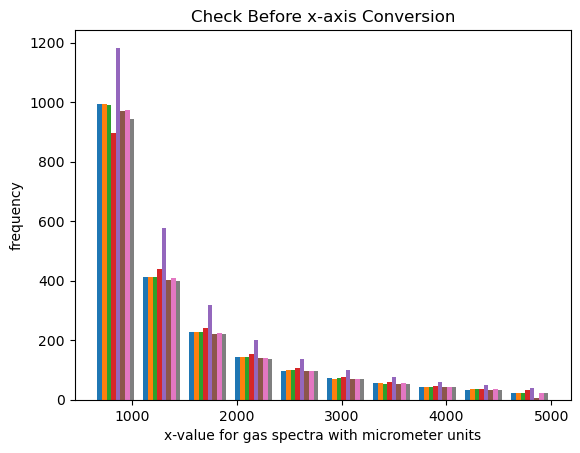

In [87]:
# Now after let's check and see how things went

x_check = []

i = 0
for cas in df.loc[gas & microm,:].index:
    ind = spec_dict['cas'].index(cas)
    if i == 0:
        plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
        plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
        plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
        plt.title('Spectrum of ' + df.loc[cas,'title'])
        plt.show()
    x_check.append(spec_dict['x'][ind].tolist())
    i += 1

plt.hist(x_check)

plt.xlabel('x-value for gas spectra with micrometer units')
plt.ylabel('frequency')
  
plt.title('Check Before x-axis Conversion')

That went as expected now move on to checking on other items that may need cleaned up

In [88]:
# Starting x?

df.loc[gas,:].firstx.value_counts()

450.000000     2715
549.800000     2452
550.000000     2103
549.900000      483
501.500000      301
551.700000      128
460.000000        3
462.000000        3
457.000000        2
4901.960784       2
451.000000        1
466.000000        1
575.652000        1
469.225000        1
605.050000        1
468.000000        1
458.000000        1
383.197000        1
3999.709000       1
4899.559040       1
390.000000        1
385.000000        1
456.012000        1
402.792000        1
463.438000        1
272.000000        1
456.206000        1
456.875000        1
390.415000        1
350.341000        1
456.000000        1
394.000000        1
395.000000        1
402.486000        1
300.654000        1
402.089000        1
457.891000        1
192.941000        1
459.000000        1
4933.399112       1
456.047000        1
391.704000        1
460.650000        1
454.206000        1
5015.045135       1
392.000000        1
587.635000        1
4992.511233       1
4666.355576       1
455.163000        1


In [89]:
# Ending x?

df.loc[gas,:].lastx.value_counts()

3966.000000    2715
4000.700000    2649
3846.000000    2103
3999.500000     483
4000.800000     223
3999.200000       9
3798.000000       4
3796.000000       4
3800.000000       3
3792.000000       2
3768.000000       1
3816.460000       1
3797.720000       1
399.199000        1
3974.603000       1
3766.000000       1
3797.980000       1
3805.280000       1
3794.000000       1
3804.700000       1
3810.000000       1
3790.000000       1
3786.430000       1
3788.760000       1
3798.950000       1
3799.630000       1
3786.000000       1
3788.000000       1
4020.520000       1
3782.000000       1
3795.030000       1
4004.710000       1
3795.050000       1
625.731323        1
3797.580000       1
4000.530000       1
625.007813        1
625.516051        1
3765.590000       1
3801.140000       1
3799.820000       1
3741.130000       1
667.650338        1
3902.940000       1
666.045025        1
625.273557        1
3751.380000       1
3801.420000       1
3795.690000       1
3803.380000       1


In [170]:
# deltax?

df.loc[gas,:].deltax.value_counts()

4.000000    4818
1.928980    2220
1.929340     483
3.857960     429
1.929000     223
1.929180       9
1.000000       4
0.937503       2
0.939706       1
1.171875       1
0.870107       1
1.006030       1
0.878220       1
0.936331       1
0.964500       1
0.879767       1
0.888327       1
0.936771       1
0.937502       1
0.876682       1
0.866873       1
0.006700       1
0.939705       1
0.938676       1
1.045753       1
1.305486       1
0.006633       1
0.935748       1
1.045755       1
0.006635       1
0.006645       1
0.935163       1
0.949969       1
0.936915       1
0.934581       1
0.006231       1
0.927358       1
0.004749       1
0.006806       1
1.358703       1
0.006863       1
Name: deltax, dtype: int64

In [117]:
# Going to drop these columns from the gas df.  Many of the columns were missing 6000 or greater data points so I
# dropped all of those columns

df_gas = df.loc[gas,:]

col_drop = (df_gas.isna().sum() > 6000).tolist()

df_gas = df_gas.drop(labels = df_gas.loc[:,col_drop].columns.tolist(), axis = 1)

In [119]:
df_gas.isna().sum()

name                0
formula             0
molecular_weight    0
image               0
title               0
jcamp-dx            0
data type           0
origin              0
owner               0
cas registry no     0
molform             0
$nist source        0
state               0
xunits              0
yunits              0
xfactor             0
yfactor             0
deltax              0
firstx              0
lastx               0
firsty              0
maxx                0
minx                0
maxy                0
miny                0
npoints             0
xydata              0
end                 0
filename            0
dtype: int64

# Not Using these cells right now marked for deletion

In [ ]:
def scrape_inchi(cas_ls, params, data_dir):
	'''Collect Inchi keys from NIST database and store them in txt format.
    Args:
        cas_ls: (list) CAS ids to download data for
		params: (dict) queries to be added to url
		data_dir: (string) path to store the data
    Returns:
        None
    '''	

	#Create file path for storing inchi keys
	inchi_path = os.path.join(data_dir, 'inchi.txt')
	num_created = 0
	with open(inchi_path,'a') as file:
		content = '{}\t{}\n'.format('cas_id', 'inchi')
		file.write(content)

		for cas_id in cas_ls:
			params['GetInChI'] = 'C' + cas_id
			response = requests.get(nist_url, params=params)

			num_created+=1
			logging.info('Creating InChi key for id: {}. Total keys created {}'.format(cas_id, num_created))
			content = '{}\t{}\n'.format(cas_id,response.content.decode("utf-8"))
			file.write(content)

In [ ]:
# All code to used if you're running this from the command line.
# I'm trying to run this in a Jupyter notebook.

#parser = argparse.ArgumentParser()
#parser.add_argument('--save_dir', default= './data',\
#     help = "Directory path to store scrapped data")
#parser.add_argument('--cas_list', default= 'species.txt',\
#    help = "File containing CAS number and formula of molecules")
#parser.add_argument('--scrape_IR', default= True,\
#    help = "Whether to download IR or not")
#parser.add_argument('--scrape_InChi', default= True,\
#    help = "Whether to download InChi or not")

In [ ]:
# Command line stuff
#args = parser.parse_args()

cas_list = 'species.txt'

#Check if file containing CAS ids exist
assert os.path.isfile(cas_list),"No file named {} exists".format(cas_list)

# Removing this until I figure out how to bring in models.util
#set_logger(data_dir, 'scrape.log')

In [ ]:
meta_dict['cas'].append(cas)

In [ ]:
# Setting the dict that I'll be adding all of the spectra to

spec_dict = {'cas':[], 'x':[], 'y':[]}
spec_dict['cas'].append(str(cas))
spec_dict['x'].append(data['x'])
spec_dict['y'].append(data['y'])

print(spec_dict)

# Then I will drop the spectra from the jcamp dict

del data['x']
del data['y']

specmeta = pd.DataFrame(data, index = [str(cas)])